In [1]:
import os
import glob
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from keras import optimizers
from keras.utils import to_categorical
from keras.layers import Dense, Input
from keras.models import Model, load_model
from keras.applications import MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
dataPath = "./Test0913.npz"
data = np.load(dataPath)

X_data = data['X_data']
y_data = data['y_data']
i_data = data['i_data']

data.close()

print("X_data: ", X_data.shape)
print("y_data: ", y_data.shape)
print("i_data: ", i_data.shape)

X_data:  (13500, 16, 16, 3)
y_data:  (13500,)
i_data:  (13500,)


In [3]:
# Data split

# Set random seed for reproductivity
seed = 42

# Train - Test split
X_train, X_test, y_train, y_test, i_train, i_test = train_test_split(X_data, y_data, i_data, test_size= 0.2, shuffle= True, random_state= seed, stratify= y_data)

# Train - Validation split
X_train, X_val, y_train, y_val, i_train, i_val = train_test_split(X_train, y_train, i_train, test_size= 0.2, shuffle= True, random_state= seed, stratify= y_train)

print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)
print(i_train.shape, i_test.shape, i_val.shape)

print(np.unique(y_train, return_counts= True))
print(np.unique(y_test, return_counts= True))
print(np.unique(y_val, return_counts= True))

(8640, 16, 16, 3) (2700, 16, 16, 3) (2160, 16, 16, 3)
(8640,) (2700,) (2160,)
(8640,) (2700,) (2160,)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64), array([960, 960, 960, 960, 960, 960, 960, 960, 960], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64), array([300, 300, 300, 300, 300, 300, 300, 300, 300], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64), array([240, 240, 240, 240, 240, 240, 240, 240, 240], dtype=int64))


In [4]:
# One - hot encoding
trainTargets = to_categorical(y_train)
testTargets = to_categorical(y_test)
valTargets = to_categorical(y_val)

print("Train targets: ", trainTargets.shape)
print("Test targets: ", testTargets.shape)
print("Validation targets: ", valTargets.shape)

Train targets:  (8640, 9)
Test targets:  (2700, 9)
Validation targets:  (2160, 9)


In [5]:
with tf.device("/device:GPU:0"):
    inputTensor = Input(shape= (16, 16, 3))

    model = MobileNetV2(input_tensor= inputTensor,
                        include_top= False,
                        weights= None,
                        pooling= 'max')

    x = model.output
    x = Dense(9, activation= 'softmax', kernel_initializer= 'he_normal')(x)

    model = Model(model.input, x)

    optim = optimizers.SGD(learning_rate= 0.01,
                           decay= 1e-3,
                           momentum= 0.9,
                           nesterov= True)

    model.compile(optimizer= optim,
                  loss= 'categorical_crossentropy',
                  metrics= ['accuracy'])

    print("Training ===================================================")
    startTime = time.time()

    history = model.fit(X_train, trainTargets,
                        batch_size= 16,
                        epochs= 150,
                        verbose= 1,
                        validation_data= (X_val, valTargets))

    endTime = time.time()

    print(f"Training time: {np.round(endTime - startTime), 3} sec")

    model.save("Test0913_weights.h5")

    print("Score for train dataset")
    score = model.evaluate(X_train, trainTargets, verbose= 1)
    print(f"Score: \n{model.metrics_names[0]} : {score[0]}\n{model.metrics_names[1]} : {score[1] * 100}%")

Training ===================================================
Epoch 1/150
540/540 [==============================] - 23s 26ms/step - loss: 1.7853 - accuracy: 0.4441 - val_loss: 2.2927 - val_accuracy: 0.1111
Epoch 2/150
540/540 [==============================] - 14s 25ms/step - loss: 0.8820 - accuracy: 0.6728 - val_loss: 2.4196 - val_accuracy: 0.1111
Epoch 3/150
540/540 [==============================] - 14s 25ms/step - loss: 0.6217 - accuracy: 0.7657 - val_loss: 2.5745 - val_accuracy: 0.1333
Epoch 4/150
540/540 [==============================] - 14s 26ms/step - loss: 0.4716 - accuracy: 0.8226 - val_loss: 2.4735 - val_accuracy: 0.1245
Epoch 5/150
540/540 [==============================] - 13s 25ms/step - loss: 0.3779 - accuracy: 0.8598 - val_loss: 2.4184 - val_accuracy: 0.1671
Epoch 6/150
540/540 [==============================] - 14s 25ms/step - loss: 0.3247 - accuracy: 0.8801 - val_loss: 2.4262 - val_accuracy: 0.1352
Epoch 7/150
540/540 [==============================] - 14s 27ms/step 

In [6]:
def plotHistory(history, train, validation):
    """
        plot training history
        Parameters
        ------------------------------
        history = history
        train = 'accuracy' or 'loss'
        validation = 'val_accuracy' or 'val_loss'
    """
    plt.figure(figsize= (8, 6))
    plt.plot(history.history[train])
    plt.plot(history.history[validation])
    plt.legend(['train', 'validation'], loc= 'center right')
    plt.xlabel("Epochs")
    if train == 'accuracy':
        plt.ylabel("Accuracy")
        plt.title(f"Accuracy for train dataset")
    elif train == "loss":
        plt.ylabel("Loss")
        plt.title("Loss for train dataset")
    plt.show()

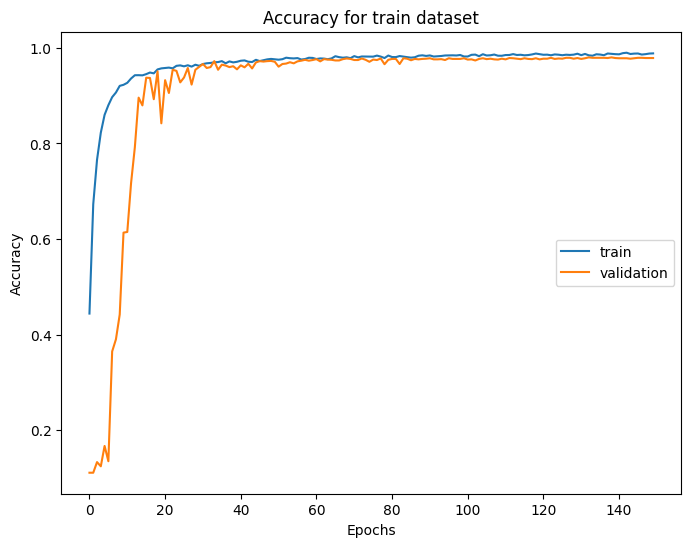

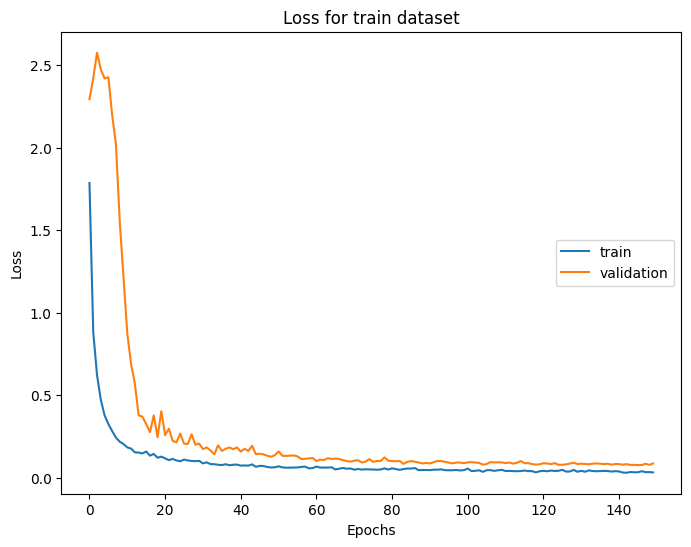

In [7]:
plotHistory(history= history, train= 'accuracy', validation= 'val_accuracy')
plotHistory(history= history, train= 'loss', validation= 'val_loss')

In [8]:
# Evaluate test dataset
testScore = model.evaluate(X_test, testTargets, verbose= 1)
print(f"{model.metrics_names[0]} : {testScore[0]}\n{model.metrics_names[1]} : {testScore[1] * 100} %")

85/85 [==============================] - 1s 11ms/step - loss: 0.0866 - accuracy: 0.9774
loss : 0.08657916635274887
accuracy : 97.74073958396912 %


85/85 [==============================] - 1s 6ms/step
Classification report: 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       300
           1       1.00      1.00      1.00       300
           2       1.00      1.00      1.00       300
           3       0.99      1.00      1.00       300
           4       1.00      0.99      0.99       300
           5       0.92      0.90      0.91       300
           6       1.00      0.98      0.99       300
           7       0.98      1.00      0.99       300
           8       0.91      0.92      0.92       300

    accuracy                           0.98      2700
   macro avg       0.98      0.98      0.98      2700
weighted avg       0.98      0.98      0.98      2700



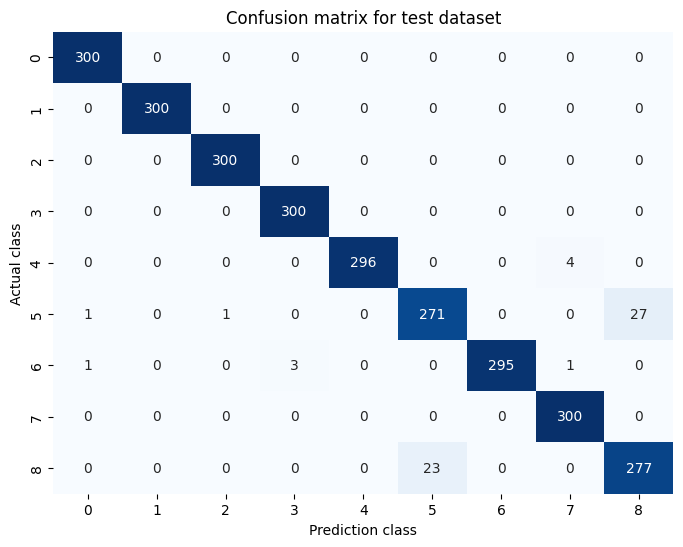

In [9]:
# Prediction for test dataset

prediction = model.predict(X_test)
predictionClass = np.argmax(prediction, axis= 1)        # One-hot encoding --> Original label

# Actual Class (One-hot encoding testTarget --> y_test)
if testTargets.ndim > 1:
    actualClass = np.argmax(testTargets, axis= 1)
else:
    actualClass = testTargets

# Classification report
print(f"Classification report: \n{classification_report(actualClass, predictionClass)}")

# Confusion matrix
plt.figure(figsize= (8, 6))
sns.heatmap(confusion_matrix(actualClass, predictionClass), 
            annot= True, 
            fmt= "d", 
            cmap= "Blues",
            cbar= False)
plt.title("Confusion matrix for test dataset")
plt.xlabel("Prediction class")
plt.ylabel("Actual class")
plt.show()

In [10]:
# Prediction for 1 image

randomImgIdx = random.randrange(0, X_test.shape[0])

predictStartTime = time.time()

predictionImg = X_test[randomImgIdx]
predictionImg = np.expand_dims(predictionImg, axis= 0)

testPrediction = model.predict(predictionImg)

predictEndTime = time.time()

print("Random image index: ", randomImgIdx)
print("Random actual label: ", i_test[randomImgIdx])
print("Random actual class: ", actualClass[randomImgIdx])
print("Random prediction class: ", predictionClass[randomImgIdx])

1/1 [==============================] - 0s 249ms/step
Random image index:  1146
Random actual label:  C3_617
Random actual class:  2
Random prediction class:  2
